In [1]:
!pip install torchinfo

In [2]:
!pip install gdown

In [6]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torchinfo'

In [4]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 모델 가중치 저장 경로 설정
model_weight_path = "./model_weights.pth"

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [6]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [7]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [11]:
# class AttentionDownsample(nn.Module):
#     def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
#         super(AttentionDownsample, self).__init__()
#         self.num_heads = num_heads
#         self.scale = (dim // num_heads) ** -0.5
#         inner_dim = dim * attn_ratio * num_heads
#         self.kv = LinearNorm(dim, inner_dim)

#         self.q = nn.Sequential(
#             nn.Conv2d(dim, dim, kernel_size=2, stride=2),
#             nn.Flatten(start_dim=1)
#         )

#         self.proj = nn.Sequential(
#             nn.Hardswish(),
#             LinearNorm(dim, out_dim)
#         )

#     def forward(self, x):
#         B, N, C = x.shape
#         H = W = int(N ** 0.5)
#         x = x.reshape(B, C, H, W)

#         kv = self.kv(x.flatten(2).transpose(1, 2))
#         q = self.q(x)

#         q = q.reshape(B, -1, C)
#         x = self.proj(q)
#         return x

In [12]:
# class LevitDownsample(nn.Module):
#     def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
#         super(LevitDownsample, self).__init__()
#         self.attn_downsample = AttentionDownsample(dim, out_dim, num_heads, attn_ratio)
#         self.mlp = LevitMlp(out_dim, out_dim * attn_ratio, out_dim)
#         self.drop_path = nn.Identity()

#     def forward(self, x):
#         x = self.attn_downsample(x)
#         x = self.drop_path(self.mlp(x))
#         return x

In [13]:
#CNNDownSample 적용
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [14]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [15]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x


In [17]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=100):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [18]:
model = LevitDistilled()
# model = LauncherModel()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 1e-6
num_epochs = 500

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [19]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [20]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_data = datasets.CIFAR100(root="data", train=True, transform=transform, download=True)
test_data = datasets.CIFAR100(root="data", train=False, transform=transform, download=True)
combined_data = ConcatDataset([train_data, test_data])

train_size = int(0.7 * len(combined_data))
val_size = int(0.15 * len(combined_data))
test_size = len(combined_data) - train_size - val_size
train_data, val_data, test_data = random_split(combined_data, [train_size, val_size, test_size])

100%|██████████| 169M/169M [00:12<00:00, 13.0MB/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [23]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 42000
Validation size: 9000
Test size: 9000


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [26]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    if phase == "Validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [27]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [28]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/500


Training: 100%|██████████| 1313/1313 [01:35<00:00, 13.77it/s]


Train Loss: 4.5863, Train Accuracy: 2.26%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 4.4510, Validation Accuracy: 3.72%

Epoch 2/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 4.4037, Train Accuracy: 4.48%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.17it/s]


Validation Loss: 4.3378, Validation Accuracy: 5.77%

Epoch 3/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 4.3148, Train Accuracy: 5.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 4.2555, Validation Accuracy: 6.81%

Epoch 4/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 4.2536, Train Accuracy: 6.29%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 4.2044, Validation Accuracy: 7.19%

Epoch 5/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 4.2066, Train Accuracy: 6.88%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 4.1624, Validation Accuracy: 7.60%

Epoch 6/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 4.1691, Train Accuracy: 7.40%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 4.1207, Validation Accuracy: 8.20%

Epoch 7/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 4.1338, Train Accuracy: 7.83%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 4.0861, Validation Accuracy: 8.82%

Epoch 8/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 4.1048, Train Accuracy: 7.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 4.0557, Validation Accuracy: 9.78%

Epoch 9/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 4.0787, Train Accuracy: 8.23%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 4.0190, Validation Accuracy: 9.88%

Epoch 10/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 4.0499, Train Accuracy: 8.69%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 3.9970, Validation Accuracy: 10.27%

Epoch 11/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 4.0293, Train Accuracy: 9.15%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 3.9714, Validation Accuracy: 10.74%

Epoch 12/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 4.0076, Train Accuracy: 9.23%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 3.9475, Validation Accuracy: 10.80%

Epoch 13/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 3.9857, Train Accuracy: 9.66%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.9243, Validation Accuracy: 11.12%

Epoch 14/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 3.9654, Train Accuracy: 9.91%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 3.9074, Validation Accuracy: 11.71%

Epoch 15/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 3.9478, Train Accuracy: 10.08%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 3.8905, Validation Accuracy: 11.24%

Epoch 16/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.9287, Train Accuracy: 10.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 3.8688, Validation Accuracy: 11.67%

Epoch 17/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 3.9141, Train Accuracy: 10.75%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 3.8555, Validation Accuracy: 11.90%

Epoch 18/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 3.8997, Train Accuracy: 10.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 3.8327, Validation Accuracy: 12.29%

Epoch 19/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 3.8853, Train Accuracy: 11.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.8152, Validation Accuracy: 12.68%

Epoch 20/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 3.8718, Train Accuracy: 11.13%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 3.8004, Validation Accuracy: 12.76%

Epoch 21/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 3.8532, Train Accuracy: 11.41%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 3.7909, Validation Accuracy: 13.10%

Epoch 22/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 3.8431, Train Accuracy: 11.60%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 3.7814, Validation Accuracy: 12.83%

Epoch 23/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 3.8300, Train Accuracy: 11.84%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 3.7615, Validation Accuracy: 13.31%

Epoch 24/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 3.8175, Train Accuracy: 11.90%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.22it/s]


Validation Loss: 3.7460, Validation Accuracy: 13.80%

Epoch 25/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.95it/s]


Train Loss: 3.8023, Train Accuracy: 12.22%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 3.7465, Validation Accuracy: 13.28%

Epoch 26/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 3.7888, Train Accuracy: 12.40%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 3.7223, Validation Accuracy: 13.92%

Epoch 27/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 3.7784, Train Accuracy: 12.76%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 3.7122, Validation Accuracy: 14.08%

Epoch 28/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 3.7646, Train Accuracy: 12.89%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 3.6965, Validation Accuracy: 14.56%

Epoch 29/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.7513, Train Accuracy: 13.11%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 3.6767, Validation Accuracy: 15.02%

Epoch 30/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.7389, Train Accuracy: 13.25%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.35it/s]


Validation Loss: 3.6733, Validation Accuracy: 14.57%

Epoch 31/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 3.7270, Train Accuracy: 13.60%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 3.6529, Validation Accuracy: 14.89%

Epoch 32/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 3.7155, Train Accuracy: 13.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 3.6416, Validation Accuracy: 15.38%

Epoch 33/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 3.7014, Train Accuracy: 13.66%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 3.6393, Validation Accuracy: 15.43%

Epoch 34/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 3.6927, Train Accuracy: 14.26%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 3.6192, Validation Accuracy: 15.53%

Epoch 35/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.97it/s]


Train Loss: 3.6802, Train Accuracy: 14.08%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.40it/s]


Validation Loss: 3.6020, Validation Accuracy: 15.99%

Epoch 36/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 3.6684, Train Accuracy: 14.52%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 3.5925, Validation Accuracy: 16.18%

Epoch 37/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 3.6501, Train Accuracy: 14.74%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.5743, Validation Accuracy: 16.43%

Epoch 38/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 3.6414, Train Accuracy: 14.78%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 3.5722, Validation Accuracy: 16.18%

Epoch 39/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.94it/s]


Train Loss: 3.6289, Train Accuracy: 15.31%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.47it/s]


Validation Loss: 3.5596, Validation Accuracy: 16.76%

Epoch 40/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.95it/s]


Train Loss: 3.6228, Train Accuracy: 15.32%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 3.5478, Validation Accuracy: 16.83%

Epoch 41/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.93it/s]


Train Loss: 3.6051, Train Accuracy: 15.70%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 3.5263, Validation Accuracy: 17.24%

Epoch 42/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 3.5951, Train Accuracy: 15.76%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 3.5166, Validation Accuracy: 17.40%

Epoch 43/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.5854, Train Accuracy: 15.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 3.5111, Validation Accuracy: 17.26%

Epoch 44/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 3.5728, Train Accuracy: 16.24%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.40it/s]


Validation Loss: 3.4948, Validation Accuracy: 17.42%

Epoch 45/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


Train Loss: 3.5609, Train Accuracy: 16.25%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 3.4951, Validation Accuracy: 18.18%

Epoch 46/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


Train Loss: 3.5457, Train Accuracy: 16.86%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 3.4795, Validation Accuracy: 17.86%

Epoch 47/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.94it/s]


Train Loss: 3.5328, Train Accuracy: 16.85%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 3.4616, Validation Accuracy: 18.29%

Epoch 48/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 3.5305, Train Accuracy: 16.92%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 3.4547, Validation Accuracy: 18.61%

Epoch 49/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.95it/s]


Train Loss: 3.5151, Train Accuracy: 17.20%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 3.4389, Validation Accuracy: 18.66%

Epoch 50/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 3.5059, Train Accuracy: 17.33%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.4210, Validation Accuracy: 18.93%

Epoch 51/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.94it/s]


Train Loss: 3.4931, Train Accuracy: 17.51%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.42it/s]


Validation Loss: 3.4288, Validation Accuracy: 18.71%

Epoch 52/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 3.4826, Train Accuracy: 17.68%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 3.4089, Validation Accuracy: 19.10%

Epoch 53/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 3.4702, Train Accuracy: 18.24%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 3.3900, Validation Accuracy: 19.62%

Epoch 54/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.4612, Train Accuracy: 18.14%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 3.3854, Validation Accuracy: 19.67%

Epoch 55/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 3.4481, Train Accuracy: 18.59%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 3.3769, Validation Accuracy: 19.83%

Epoch 56/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 3.4378, Train Accuracy: 18.50%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 3.3701, Validation Accuracy: 19.97%

Epoch 57/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.93it/s]


Train Loss: 3.4251, Train Accuracy: 18.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.42it/s]


Validation Loss: 3.3586, Validation Accuracy: 20.04%

Epoch 58/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.90it/s]


Train Loss: 3.4167, Train Accuracy: 19.00%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.44it/s]


Validation Loss: 3.3433, Validation Accuracy: 20.87%

Epoch 59/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 3.4094, Train Accuracy: 19.20%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.25it/s]


Validation Loss: 3.3367, Validation Accuracy: 20.48%

Epoch 60/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.3958, Train Accuracy: 19.48%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 3.3220, Validation Accuracy: 21.01%

Epoch 61/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 3.3851, Train Accuracy: 19.47%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 3.3138, Validation Accuracy: 20.99%

Epoch 62/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.93it/s]


Train Loss: 3.3781, Train Accuracy: 19.61%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 3.3039, Validation Accuracy: 21.04%

Epoch 63/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 3.3643, Train Accuracy: 20.13%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 3.2937, Validation Accuracy: 21.81%

Epoch 64/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 3.3567, Train Accuracy: 20.06%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.42it/s]


Validation Loss: 3.2791, Validation Accuracy: 21.97%

Epoch 65/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 3.3489, Train Accuracy: 20.15%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.2778, Validation Accuracy: 21.56%

Epoch 66/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 3.3329, Train Accuracy: 20.61%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 3.2700, Validation Accuracy: 21.89%

Epoch 67/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.3267, Train Accuracy: 20.94%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 3.2622, Validation Accuracy: 22.27%

Epoch 68/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 3.3148, Train Accuracy: 20.89%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 3.2450, Validation Accuracy: 22.23%

Epoch 69/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.3060, Train Accuracy: 21.13%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 3.2340, Validation Accuracy: 22.41%

Epoch 70/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 3.2957, Train Accuracy: 21.57%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.2350, Validation Accuracy: 22.56%

Epoch 71/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.2847, Train Accuracy: 21.55%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 3.2247, Validation Accuracy: 22.38%

Epoch 72/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 3.2766, Train Accuracy: 21.85%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 3.2156, Validation Accuracy: 22.69%

Epoch 73/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.2712, Train Accuracy: 21.57%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 3.2014, Validation Accuracy: 23.33%

Epoch 74/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 3.2552, Train Accuracy: 22.30%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 3.1962, Validation Accuracy: 23.03%

Epoch 75/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.2485, Train Accuracy: 22.27%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.43it/s]


Validation Loss: 3.1846, Validation Accuracy: 23.20%

Epoch 76/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 3.2407, Train Accuracy: 22.38%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 3.1762, Validation Accuracy: 23.36%

Epoch 77/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 3.2270, Train Accuracy: 22.63%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 3.1811, Validation Accuracy: 23.59%

Epoch 78/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 3.2180, Train Accuracy: 22.70%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 3.1722, Validation Accuracy: 23.44%

Epoch 79/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 3.2127, Train Accuracy: 22.78%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.37it/s]


Validation Loss: 3.1661, Validation Accuracy: 23.80%

Epoch 80/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.2040, Train Accuracy: 23.00%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 3.1506, Validation Accuracy: 23.77%

Epoch 81/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 3.1913, Train Accuracy: 23.27%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 3.1504, Validation Accuracy: 24.07%

Epoch 82/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 3.1913, Train Accuracy: 23.25%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 3.1462, Validation Accuracy: 24.33%

Epoch 83/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.1762, Train Accuracy: 23.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 3.1249, Validation Accuracy: 24.29%

Epoch 84/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.1659, Train Accuracy: 23.85%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 3.1189, Validation Accuracy: 24.66%

Epoch 85/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.1582, Train Accuracy: 24.01%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 3.1115, Validation Accuracy: 24.92%

Epoch 86/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.1567, Train Accuracy: 24.03%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 3.1034, Validation Accuracy: 25.03%

Epoch 87/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 3.1391, Train Accuracy: 24.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 3.0958, Validation Accuracy: 25.04%

Epoch 88/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.1345, Train Accuracy: 24.33%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 3.0861, Validation Accuracy: 25.32%

Epoch 89/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.1307, Train Accuracy: 24.41%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 3.0922, Validation Accuracy: 25.04%

Epoch 90/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.1199, Train Accuracy: 24.61%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 3.0823, Validation Accuracy: 25.18%

Epoch 91/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 3.1055, Train Accuracy: 25.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 3.0752, Validation Accuracy: 25.81%

Epoch 92/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.0994, Train Accuracy: 24.94%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.46it/s]


Validation Loss: 3.0652, Validation Accuracy: 26.11%

Epoch 93/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 3.0929, Train Accuracy: 25.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 3.0610, Validation Accuracy: 26.14%

Epoch 94/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.0888, Train Accuracy: 25.29%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 3.0505, Validation Accuracy: 25.90%

Epoch 95/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.0812, Train Accuracy: 25.41%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 3.0630, Validation Accuracy: 25.76%

Epoch 96/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 3.0740, Train Accuracy: 25.46%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 3.0499, Validation Accuracy: 25.91%

Epoch 97/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 3.0648, Train Accuracy: 25.86%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 3.0443, Validation Accuracy: 25.93%

Epoch 98/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 3.0531, Train Accuracy: 25.94%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 3.0258, Validation Accuracy: 26.54%

Epoch 99/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 3.0523, Train Accuracy: 25.96%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 3.0320, Validation Accuracy: 26.26%

Epoch 100/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.0459, Train Accuracy: 25.94%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 3.0246, Validation Accuracy: 26.26%

Epoch 101/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.0338, Train Accuracy: 26.34%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 3.0289, Validation Accuracy: 26.02%

Epoch 102/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 3.0314, Train Accuracy: 26.38%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 3.0049, Validation Accuracy: 26.87%

Epoch 103/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 3.0245, Train Accuracy: 26.69%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.42it/s]


Validation Loss: 3.0074, Validation Accuracy: 26.64%

Epoch 104/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 3.0105, Train Accuracy: 26.94%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.9987, Validation Accuracy: 26.82%

Epoch 105/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 3.0053, Train Accuracy: 26.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.95it/s]


Validation Loss: 2.9887, Validation Accuracy: 26.86%

Epoch 106/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 3.0000, Train Accuracy: 26.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.9840, Validation Accuracy: 26.97%

Epoch 107/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.9953, Train Accuracy: 27.02%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.9825, Validation Accuracy: 26.92%

Epoch 108/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.9919, Train Accuracy: 27.13%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.9807, Validation Accuracy: 26.83%

Epoch 109/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.9836, Train Accuracy: 27.31%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.9741, Validation Accuracy: 27.11%

Epoch 110/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.9708, Train Accuracy: 27.69%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.9768, Validation Accuracy: 27.27%

Epoch 111/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.9696, Train Accuracy: 27.71%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.9766, Validation Accuracy: 27.22%

Epoch 112/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.9625, Train Accuracy: 27.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.9603, Validation Accuracy: 27.62%

Epoch 113/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 2.9542, Train Accuracy: 27.77%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.9536, Validation Accuracy: 27.80%

Epoch 114/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 2.9465, Train Accuracy: 28.10%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.9457, Validation Accuracy: 27.56%

Epoch 115/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.9374, Train Accuracy: 28.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.9435, Validation Accuracy: 27.54%

Epoch 116/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.9333, Train Accuracy: 28.28%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.9459, Validation Accuracy: 27.89%

Epoch 117/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.9281, Train Accuracy: 28.34%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.9355, Validation Accuracy: 28.32%

Epoch 118/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.9220, Train Accuracy: 28.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.01it/s]


Validation Loss: 2.9285, Validation Accuracy: 28.29%

Epoch 119/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.9164, Train Accuracy: 28.70%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.9312, Validation Accuracy: 27.79%

Epoch 120/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.9126, Train Accuracy: 28.58%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.9237, Validation Accuracy: 28.42%

Epoch 121/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 2.9134, Train Accuracy: 28.44%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.9136, Validation Accuracy: 28.30%

Epoch 122/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.8974, Train Accuracy: 28.92%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.9179, Validation Accuracy: 27.89%

Epoch 123/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.8981, Train Accuracy: 28.94%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.9123, Validation Accuracy: 28.41%

Epoch 124/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.8886, Train Accuracy: 29.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.8961, Validation Accuracy: 28.63%

Epoch 125/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.8846, Train Accuracy: 29.09%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.38it/s]


Validation Loss: 2.8951, Validation Accuracy: 28.68%

Epoch 126/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.8812, Train Accuracy: 29.49%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.8984, Validation Accuracy: 28.90%

Epoch 127/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.8722, Train Accuracy: 29.38%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.46it/s]


Validation Loss: 2.9010, Validation Accuracy: 28.58%

Epoch 128/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.8688, Train Accuracy: 29.22%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.8832, Validation Accuracy: 28.69%

Epoch 129/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.8618, Train Accuracy: 29.51%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.8798, Validation Accuracy: 29.08%

Epoch 130/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.8590, Train Accuracy: 29.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.8845, Validation Accuracy: 29.02%

Epoch 131/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 2.8532, Train Accuracy: 29.76%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.8728, Validation Accuracy: 28.93%

Epoch 132/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.8457, Train Accuracy: 29.82%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.8620, Validation Accuracy: 29.12%

Epoch 133/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.8395, Train Accuracy: 29.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.8594, Validation Accuracy: 29.53%

Epoch 134/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.8317, Train Accuracy: 30.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.8674, Validation Accuracy: 28.80%

Epoch 135/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.8296, Train Accuracy: 30.15%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 2.8496, Validation Accuracy: 29.70%

Epoch 136/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.8231, Train Accuracy: 30.38%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.90it/s]


Validation Loss: 2.8580, Validation Accuracy: 29.38%

Epoch 137/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.8157, Train Accuracy: 30.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.8449, Validation Accuracy: 29.50%

Epoch 138/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.8117, Train Accuracy: 30.47%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.8476, Validation Accuracy: 29.22%

Epoch 139/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.8135, Train Accuracy: 30.78%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.8493, Validation Accuracy: 29.14%

Epoch 140/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.7981, Train Accuracy: 30.94%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.8346, Validation Accuracy: 29.63%

Epoch 141/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.7940, Train Accuracy: 30.99%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.8358, Validation Accuracy: 29.80%

Epoch 142/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.7870, Train Accuracy: 31.22%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.8431, Validation Accuracy: 29.69%

Epoch 143/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.7806, Train Accuracy: 31.29%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.8239, Validation Accuracy: 30.00%

Epoch 144/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.7778, Train Accuracy: 31.38%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.8285, Validation Accuracy: 29.82%

Epoch 145/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.7734, Train Accuracy: 31.38%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.8171, Validation Accuracy: 30.40%

Epoch 146/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.7650, Train Accuracy: 31.56%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 2.8280, Validation Accuracy: 29.43%

Epoch 147/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.7658, Train Accuracy: 31.41%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.8117, Validation Accuracy: 29.97%

Epoch 148/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.7534, Train Accuracy: 31.75%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.8002, Validation Accuracy: 30.48%

Epoch 149/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.7540, Train Accuracy: 31.65%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.33it/s]


Validation Loss: 2.8073, Validation Accuracy: 29.98%

Epoch 150/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.7493, Train Accuracy: 31.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.8015, Validation Accuracy: 30.70%

Epoch 151/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.7442, Train Accuracy: 31.96%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.7966, Validation Accuracy: 30.50%

Epoch 152/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.7439, Train Accuracy: 32.00%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.7965, Validation Accuracy: 30.68%

Epoch 153/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.7363, Train Accuracy: 31.95%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.7972, Validation Accuracy: 30.32%

Epoch 154/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.7306, Train Accuracy: 32.22%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.7884, Validation Accuracy: 30.62%

Epoch 155/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.7215, Train Accuracy: 32.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.7931, Validation Accuracy: 30.36%

Epoch 156/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.7226, Train Accuracy: 32.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.7886, Validation Accuracy: 30.12%

Epoch 157/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.7171, Train Accuracy: 32.45%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 2.7854, Validation Accuracy: 30.38%

Epoch 158/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.7110, Train Accuracy: 32.71%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.7861, Validation Accuracy: 30.31%

Epoch 159/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.7090, Train Accuracy: 32.68%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.7802, Validation Accuracy: 30.63%

Epoch 160/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.7035, Train Accuracy: 32.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.7671, Validation Accuracy: 30.71%

Epoch 161/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.6981, Train Accuracy: 32.65%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.7704, Validation Accuracy: 31.39%

Epoch 162/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.6935, Train Accuracy: 32.83%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.7670, Validation Accuracy: 31.03%

Epoch 163/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.6824, Train Accuracy: 33.18%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.7559, Validation Accuracy: 31.02%

Epoch 164/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.6850, Train Accuracy: 33.07%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.7680, Validation Accuracy: 30.82%

Epoch 165/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.6805, Train Accuracy: 33.03%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.7676, Validation Accuracy: 31.26%

Epoch 166/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.6763, Train Accuracy: 33.41%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.7525, Validation Accuracy: 31.09%

Epoch 167/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.6740, Train Accuracy: 33.60%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.7617, Validation Accuracy: 30.91%

Epoch 168/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.6683, Train Accuracy: 33.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.7582, Validation Accuracy: 30.89%

Epoch 169/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.6625, Train Accuracy: 33.54%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.7614, Validation Accuracy: 31.06%

Epoch 170/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.6585, Train Accuracy: 33.77%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.7453, Validation Accuracy: 31.09%

Epoch 171/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.6522, Train Accuracy: 33.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.7500, Validation Accuracy: 31.38%

Epoch 172/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.6508, Train Accuracy: 33.86%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.7428, Validation Accuracy: 31.33%

Epoch 173/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.6505, Train Accuracy: 33.66%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.7332, Validation Accuracy: 31.80%

Epoch 174/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.6376, Train Accuracy: 33.98%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.7447, Validation Accuracy: 31.28%

Epoch 175/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.6330, Train Accuracy: 34.06%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.7419, Validation Accuracy: 31.23%

Epoch 176/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.6310, Train Accuracy: 34.28%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 2.7392, Validation Accuracy: 31.77%

Epoch 177/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 2.6254, Train Accuracy: 34.25%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.7330, Validation Accuracy: 31.74%

Epoch 178/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.6233, Train Accuracy: 34.09%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.46it/s]


Validation Loss: 2.7215, Validation Accuracy: 31.69%

Epoch 179/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 2.6183, Train Accuracy: 34.40%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 2.7209, Validation Accuracy: 31.58%

Epoch 180/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


Train Loss: 2.6214, Train Accuracy: 34.50%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.7297, Validation Accuracy: 31.81%

Epoch 181/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.6126, Train Accuracy: 34.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.7204, Validation Accuracy: 32.11%

Epoch 182/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.6029, Train Accuracy: 34.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.7128, Validation Accuracy: 31.44%

Epoch 183/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.6007, Train Accuracy: 34.84%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.7187, Validation Accuracy: 31.96%

Epoch 184/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.5988, Train Accuracy: 34.98%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.7111, Validation Accuracy: 31.76%

Epoch 185/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.5943, Train Accuracy: 34.99%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.7102, Validation Accuracy: 32.08%

Epoch 186/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.5849, Train Accuracy: 35.07%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.20it/s]


Validation Loss: 2.7062, Validation Accuracy: 31.76%

Epoch 187/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.5839, Train Accuracy: 35.06%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.7037, Validation Accuracy: 32.16%

Epoch 188/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.5823, Train Accuracy: 35.02%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.6946, Validation Accuracy: 31.97%

Epoch 189/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.5718, Train Accuracy: 35.16%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.7064, Validation Accuracy: 31.70%

Epoch 190/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.5696, Train Accuracy: 35.54%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.7066, Validation Accuracy: 31.92%

Epoch 191/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.5694, Train Accuracy: 35.28%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.6926, Validation Accuracy: 32.83%

Epoch 192/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.5686, Train Accuracy: 35.32%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.6878, Validation Accuracy: 32.29%

Epoch 193/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.5622, Train Accuracy: 35.67%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.6909, Validation Accuracy: 32.11%

Epoch 194/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.5597, Train Accuracy: 35.74%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.32it/s]


Validation Loss: 2.7013, Validation Accuracy: 32.10%

Epoch 195/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.5504, Train Accuracy: 35.93%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.6740, Validation Accuracy: 32.57%

Epoch 196/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.5484, Train Accuracy: 35.79%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.6903, Validation Accuracy: 32.68%

Epoch 197/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.5468, Train Accuracy: 35.84%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.6806, Validation Accuracy: 32.43%

Epoch 198/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.5438, Train Accuracy: 35.54%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.6759, Validation Accuracy: 32.57%

Epoch 199/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.5313, Train Accuracy: 36.23%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.36it/s]


Validation Loss: 2.6700, Validation Accuracy: 32.94%

Epoch 200/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.5377, Train Accuracy: 35.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.6845, Validation Accuracy: 32.09%

Epoch 201/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.5285, Train Accuracy: 36.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.6771, Validation Accuracy: 32.82%

Epoch 202/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.5222, Train Accuracy: 36.37%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.6696, Validation Accuracy: 32.52%

Epoch 203/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.5221, Train Accuracy: 36.40%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 2.6814, Validation Accuracy: 32.82%

Epoch 204/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.5192, Train Accuracy: 36.62%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.6735, Validation Accuracy: 32.72%

Epoch 205/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


Train Loss: 2.5129, Train Accuracy: 36.63%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.6795, Validation Accuracy: 32.89%

Epoch 206/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.5101, Train Accuracy: 36.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 2.6619, Validation Accuracy: 33.27%

Epoch 207/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.5072, Train Accuracy: 36.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.6631, Validation Accuracy: 32.87%

Epoch 208/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.4967, Train Accuracy: 36.56%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.6620, Validation Accuracy: 32.96%

Epoch 209/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.5009, Train Accuracy: 36.72%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.6593, Validation Accuracy: 32.90%

Epoch 210/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.4901, Train Accuracy: 37.05%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.6550, Validation Accuracy: 32.96%

Epoch 211/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.4926, Train Accuracy: 36.89%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.6679, Validation Accuracy: 33.02%

Epoch 212/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.4892, Train Accuracy: 37.04%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.6597, Validation Accuracy: 33.53%

Epoch 213/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.4782, Train Accuracy: 37.05%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.6576, Validation Accuracy: 32.84%

Epoch 214/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.4784, Train Accuracy: 37.15%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.6512, Validation Accuracy: 32.96%

Epoch 215/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.4781, Train Accuracy: 37.45%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.6606, Validation Accuracy: 33.29%

Epoch 216/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.4654, Train Accuracy: 37.55%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 2.6476, Validation Accuracy: 33.68%

Epoch 217/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.4678, Train Accuracy: 37.48%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.6448, Validation Accuracy: 33.00%

Epoch 218/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.4556, Train Accuracy: 37.81%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.43it/s]


Validation Loss: 2.6468, Validation Accuracy: 33.29%

Epoch 219/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.4616, Train Accuracy: 37.50%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.6377, Validation Accuracy: 33.57%

Epoch 220/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.4530, Train Accuracy: 37.75%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.38it/s]


Validation Loss: 2.6356, Validation Accuracy: 33.66%

Epoch 221/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.4493, Train Accuracy: 37.81%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.6489, Validation Accuracy: 33.28%

Epoch 222/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 2.4497, Train Accuracy: 37.73%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.6451, Validation Accuracy: 33.72%

Epoch 223/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 2.4506, Train Accuracy: 37.87%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.6438, Validation Accuracy: 33.54%

Epoch 224/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.97it/s]


Train Loss: 2.4411, Train Accuracy: 38.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.6296, Validation Accuracy: 33.62%

Epoch 225/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.4401, Train Accuracy: 37.92%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.6329, Validation Accuracy: 34.07%

Epoch 226/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.97it/s]


Train Loss: 2.4328, Train Accuracy: 38.23%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.6247, Validation Accuracy: 33.63%

Epoch 227/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 2.4306, Train Accuracy: 38.12%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.31it/s]


Validation Loss: 2.6354, Validation Accuracy: 33.63%

Epoch 228/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.4271, Train Accuracy: 38.33%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.6253, Validation Accuracy: 33.57%

Epoch 229/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 2.4277, Train Accuracy: 38.42%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.6311, Validation Accuracy: 33.33%

Epoch 230/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.93it/s]


Train Loss: 2.4264, Train Accuracy: 38.20%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.6250, Validation Accuracy: 33.70%

Epoch 231/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.93it/s]


Train Loss: 2.4201, Train Accuracy: 38.56%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 2.6294, Validation Accuracy: 33.78%

Epoch 232/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.4182, Train Accuracy: 38.61%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.6286, Validation Accuracy: 33.72%

Epoch 233/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 2.4072, Train Accuracy: 38.72%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.6154, Validation Accuracy: 33.89%

Epoch 234/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 2.4044, Train Accuracy: 38.95%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.6332, Validation Accuracy: 34.02%

Epoch 235/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.3987, Train Accuracy: 38.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.38it/s]


Validation Loss: 2.6192, Validation Accuracy: 34.09%

Epoch 236/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.90it/s]


Train Loss: 2.3977, Train Accuracy: 38.98%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 2.6126, Validation Accuracy: 34.13%

Epoch 237/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 2.3953, Train Accuracy: 39.05%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.6074, Validation Accuracy: 34.03%

Epoch 238/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.97it/s]


Train Loss: 2.3932, Train Accuracy: 38.93%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.6156, Validation Accuracy: 34.04%

Epoch 239/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.97it/s]


Train Loss: 2.3880, Train Accuracy: 39.30%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.6158, Validation Accuracy: 34.21%

Epoch 240/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.86it/s]


Train Loss: 2.3877, Train Accuracy: 39.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.35it/s]


Validation Loss: 2.6116, Validation Accuracy: 34.18%

Epoch 241/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.95it/s]


Train Loss: 2.3827, Train Accuracy: 39.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.37it/s]


Validation Loss: 2.5965, Validation Accuracy: 34.31%

Epoch 242/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.3774, Train Accuracy: 39.53%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.34it/s]


Validation Loss: 2.6049, Validation Accuracy: 34.60%

Epoch 243/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.92it/s]


Train Loss: 2.3681, Train Accuracy: 39.77%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.6110, Validation Accuracy: 34.51%

Epoch 244/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.3686, Train Accuracy: 39.50%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.6014, Validation Accuracy: 34.21%

Epoch 245/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


Train Loss: 2.3709, Train Accuracy: 39.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.6075, Validation Accuracy: 34.23%

Epoch 246/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


Train Loss: 2.3610, Train Accuracy: 39.61%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.33it/s]


Validation Loss: 2.6094, Validation Accuracy: 34.30%

Epoch 247/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.3639, Train Accuracy: 39.70%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.44it/s]


Validation Loss: 2.5935, Validation Accuracy: 34.59%

Epoch 248/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.98it/s]


Train Loss: 2.3456, Train Accuracy: 39.98%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.41it/s]


Validation Loss: 2.5951, Validation Accuracy: 34.44%

Epoch 249/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.3527, Train Accuracy: 39.89%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.5925, Validation Accuracy: 34.49%

Epoch 250/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.3564, Train Accuracy: 39.64%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.6049, Validation Accuracy: 34.57%

Epoch 251/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.3488, Train Accuracy: 39.93%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.5982, Validation Accuracy: 34.79%

Epoch 252/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.3482, Train Accuracy: 39.82%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.6037, Validation Accuracy: 34.63%

Epoch 253/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.3396, Train Accuracy: 40.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.5895, Validation Accuracy: 34.83%

Epoch 254/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.96it/s]


Train Loss: 2.3373, Train Accuracy: 40.21%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.44it/s]


Validation Loss: 2.5828, Validation Accuracy: 34.68%

Epoch 255/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.3351, Train Accuracy: 40.21%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.5930, Validation Accuracy: 34.44%

Epoch 256/500


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.97it/s]


Train Loss: 2.3308, Train Accuracy: 40.41%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.39it/s]


Validation Loss: 2.5781, Validation Accuracy: 34.99%

Epoch 257/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.3242, Train Accuracy: 40.66%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.5936, Validation Accuracy: 34.79%

Epoch 258/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.3278, Train Accuracy: 40.43%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.5818, Validation Accuracy: 34.83%

Epoch 259/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.3198, Train Accuracy: 40.72%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.5659, Validation Accuracy: 35.07%

Epoch 260/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.3155, Train Accuracy: 40.50%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.5731, Validation Accuracy: 34.86%

Epoch 261/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.3138, Train Accuracy: 40.76%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.5691, Validation Accuracy: 35.12%

Epoch 262/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.3115, Train Accuracy: 40.69%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.5657, Validation Accuracy: 35.00%

Epoch 263/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.3100, Train Accuracy: 40.72%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.5719, Validation Accuracy: 35.24%

Epoch 264/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.3054, Train Accuracy: 40.86%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.5811, Validation Accuracy: 35.08%

Epoch 265/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.2970, Train Accuracy: 41.06%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.5665, Validation Accuracy: 35.09%

Epoch 266/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.2942, Train Accuracy: 41.16%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.5876, Validation Accuracy: 34.91%

Epoch 267/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.99it/s]


Train Loss: 2.2937, Train Accuracy: 41.36%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.5745, Validation Accuracy: 35.09%

Epoch 268/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.2872, Train Accuracy: 41.06%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.39it/s]


Validation Loss: 2.5635, Validation Accuracy: 35.37%

Epoch 269/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.2859, Train Accuracy: 41.30%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.5838, Validation Accuracy: 35.01%

Epoch 270/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.2847, Train Accuracy: 41.18%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 2.5718, Validation Accuracy: 34.96%

Epoch 271/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 2.2813, Train Accuracy: 41.18%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.5732, Validation Accuracy: 34.87%

Epoch 272/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.2771, Train Accuracy: 41.32%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.46it/s]


Validation Loss: 2.5721, Validation Accuracy: 35.03%

Epoch 273/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.2682, Train Accuracy: 41.87%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.5709, Validation Accuracy: 35.11%

Epoch 274/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.2693, Train Accuracy: 41.51%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.22it/s]


Validation Loss: 2.5628, Validation Accuracy: 35.24%

Epoch 275/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.2677, Train Accuracy: 41.82%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.5642, Validation Accuracy: 35.51%

Epoch 276/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.2663, Train Accuracy: 41.75%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.37it/s]


Validation Loss: 2.5491, Validation Accuracy: 35.69%

Epoch 277/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.2655, Train Accuracy: 41.58%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.5709, Validation Accuracy: 35.11%

Epoch 278/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.2639, Train Accuracy: 41.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.5529, Validation Accuracy: 35.39%

Epoch 279/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.2499, Train Accuracy: 42.19%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.5503, Validation Accuracy: 35.69%

Epoch 280/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


Train Loss: 2.2492, Train Accuracy: 42.26%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.5637, Validation Accuracy: 35.58%

Epoch 281/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.2476, Train Accuracy: 42.37%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.5566, Validation Accuracy: 35.54%

Epoch 282/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.2430, Train Accuracy: 42.18%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.5613, Validation Accuracy: 35.50%

Epoch 283/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.2441, Train Accuracy: 42.12%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.5688, Validation Accuracy: 35.11%

Epoch 284/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.2339, Train Accuracy: 42.55%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.5643, Validation Accuracy: 35.54%

Epoch 285/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.2347, Train Accuracy: 42.40%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.5580, Validation Accuracy: 35.50%

Epoch 286/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.2367, Train Accuracy: 42.40%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.5533, Validation Accuracy: 35.70%

Epoch 287/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.2240, Train Accuracy: 42.73%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.5553, Validation Accuracy: 35.82%

Epoch 288/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.2230, Train Accuracy: 42.86%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.5551, Validation Accuracy: 35.56%

Epoch 289/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.2199, Train Accuracy: 42.83%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.5484, Validation Accuracy: 36.03%

Epoch 290/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.2189, Train Accuracy: 42.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.5481, Validation Accuracy: 36.14%

Epoch 291/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 2.2132, Train Accuracy: 42.83%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.5763, Validation Accuracy: 35.13%

Epoch 292/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.2113, Train Accuracy: 42.93%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.5490, Validation Accuracy: 36.04%

Epoch 293/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 2.2169, Train Accuracy: 42.78%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.54it/s]


Validation Loss: 2.5419, Validation Accuracy: 35.57%

Epoch 294/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.2055, Train Accuracy: 42.94%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.5383, Validation Accuracy: 35.97%

Epoch 295/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.2037, Train Accuracy: 43.01%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.5401, Validation Accuracy: 36.06%

Epoch 296/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1959, Train Accuracy: 43.26%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.5491, Validation Accuracy: 35.80%

Epoch 297/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.1952, Train Accuracy: 43.32%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.5438, Validation Accuracy: 35.94%

Epoch 298/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 2.1909, Train Accuracy: 43.50%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.5453, Validation Accuracy: 36.07%

Epoch 299/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.1844, Train Accuracy: 43.56%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.5365, Validation Accuracy: 36.01%

Epoch 300/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.1860, Train Accuracy: 43.54%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.47it/s]


Validation Loss: 2.5425, Validation Accuracy: 35.77%

Epoch 301/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.1838, Train Accuracy: 43.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.5267, Validation Accuracy: 35.68%

Epoch 302/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.1806, Train Accuracy: 43.56%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.5451, Validation Accuracy: 35.96%

Epoch 303/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.1770, Train Accuracy: 43.57%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.5464, Validation Accuracy: 35.90%

Epoch 304/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1751, Train Accuracy: 43.68%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.43it/s]


Validation Loss: 2.5365, Validation Accuracy: 36.47%

Epoch 305/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.1735, Train Accuracy: 43.69%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.5294, Validation Accuracy: 36.32%

Epoch 306/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.1689, Train Accuracy: 43.89%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.5506, Validation Accuracy: 36.26%

Epoch 307/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.1628, Train Accuracy: 44.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.5381, Validation Accuracy: 36.08%

Epoch 308/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 2.1667, Train Accuracy: 44.00%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.5212, Validation Accuracy: 36.48%

Epoch 309/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1603, Train Accuracy: 44.00%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 2.5331, Validation Accuracy: 36.64%

Epoch 310/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.1571, Train Accuracy: 44.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.5342, Validation Accuracy: 36.26%

Epoch 311/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.1561, Train Accuracy: 44.12%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.5273, Validation Accuracy: 36.19%

Epoch 312/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.1486, Train Accuracy: 44.49%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.5233, Validation Accuracy: 36.41%

Epoch 313/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1439, Train Accuracy: 44.04%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.5221, Validation Accuracy: 36.50%

Epoch 314/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1500, Train Accuracy: 44.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.5277, Validation Accuracy: 36.13%

Epoch 315/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1411, Train Accuracy: 44.40%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.42it/s]


Validation Loss: 2.5193, Validation Accuracy: 36.84%

Epoch 316/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1430, Train Accuracy: 44.29%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.93it/s]


Validation Loss: 2.5227, Validation Accuracy: 36.39%

Epoch 317/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.1377, Train Accuracy: 44.49%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.5321, Validation Accuracy: 36.44%

Epoch 318/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.1316, Train Accuracy: 44.95%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.5232, Validation Accuracy: 36.40%

Epoch 319/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.1310, Train Accuracy: 44.70%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.5151, Validation Accuracy: 36.58%

Epoch 320/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.1307, Train Accuracy: 44.53%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.44it/s]


Validation Loss: 2.5137, Validation Accuracy: 36.86%

Epoch 321/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1228, Train Accuracy: 45.02%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.5345, Validation Accuracy: 36.37%

Epoch 322/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.1211, Train Accuracy: 44.99%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.5058, Validation Accuracy: 37.18%

Epoch 323/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1196, Train Accuracy: 45.20%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.5118, Validation Accuracy: 36.78%

Epoch 324/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 2.1098, Train Accuracy: 45.34%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.5301, Validation Accuracy: 36.68%

Epoch 325/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.1170, Train Accuracy: 44.99%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.5212, Validation Accuracy: 36.74%

Epoch 326/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.1096, Train Accuracy: 45.12%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.5239, Validation Accuracy: 36.62%

Epoch 327/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.1094, Train Accuracy: 45.08%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.5131, Validation Accuracy: 36.30%

Epoch 328/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.1100, Train Accuracy: 45.18%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.89it/s]


Validation Loss: 2.5179, Validation Accuracy: 37.11%

Epoch 329/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.1047, Train Accuracy: 45.49%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.5014, Validation Accuracy: 37.08%

Epoch 330/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.1019, Train Accuracy: 45.47%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.5022, Validation Accuracy: 37.07%

Epoch 331/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.0943, Train Accuracy: 45.57%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.5166, Validation Accuracy: 36.50%

Epoch 332/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.0961, Train Accuracy: 45.32%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.5055, Validation Accuracy: 37.29%

Epoch 333/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 2.0868, Train Accuracy: 45.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4980, Validation Accuracy: 36.87%

Epoch 334/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 2.0838, Train Accuracy: 46.04%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.4983, Validation Accuracy: 37.17%

Epoch 335/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0861, Train Accuracy: 45.67%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.5061, Validation Accuracy: 36.94%

Epoch 336/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.0826, Train Accuracy: 45.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.37it/s]


Validation Loss: 2.5013, Validation Accuracy: 37.03%

Epoch 337/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 2.0743, Train Accuracy: 45.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.5044, Validation Accuracy: 36.91%

Epoch 338/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.0726, Train Accuracy: 46.01%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 2.5088, Validation Accuracy: 36.91%

Epoch 339/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0732, Train Accuracy: 45.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.5019, Validation Accuracy: 37.19%

Epoch 340/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.0635, Train Accuracy: 46.30%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.4954, Validation Accuracy: 36.94%

Epoch 341/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.0705, Train Accuracy: 45.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.5052, Validation Accuracy: 36.62%

Epoch 342/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 2.0614, Train Accuracy: 46.50%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.4998, Validation Accuracy: 37.56%

Epoch 343/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.0643, Train Accuracy: 46.13%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 2.4962, Validation Accuracy: 37.10%

Epoch 344/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0600, Train Accuracy: 46.27%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.5060, Validation Accuracy: 37.58%

Epoch 345/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 2.0558, Train Accuracy: 46.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 2.4765, Validation Accuracy: 38.17%

Epoch 346/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.0586, Train Accuracy: 46.10%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.5029, Validation Accuracy: 37.11%

Epoch 347/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 2.0558, Train Accuracy: 46.04%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4930, Validation Accuracy: 37.87%

Epoch 348/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 2.0455, Train Accuracy: 46.62%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.5052, Validation Accuracy: 37.58%

Epoch 349/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.0477, Train Accuracy: 46.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.5031, Validation Accuracy: 37.12%

Epoch 350/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.0446, Train Accuracy: 46.69%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.4993, Validation Accuracy: 37.29%

Epoch 351/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0392, Train Accuracy: 46.75%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4941, Validation Accuracy: 37.48%

Epoch 352/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.0316, Train Accuracy: 46.98%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 2.4963, Validation Accuracy: 37.58%

Epoch 353/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.0339, Train Accuracy: 46.88%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.43it/s]


Validation Loss: 2.5089, Validation Accuracy: 37.29%

Epoch 354/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0288, Train Accuracy: 46.88%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.4981, Validation Accuracy: 37.31%

Epoch 355/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.0254, Train Accuracy: 47.09%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.4979, Validation Accuracy: 37.50%

Epoch 356/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.0253, Train Accuracy: 46.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4913, Validation Accuracy: 37.61%

Epoch 357/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 2.0151, Train Accuracy: 47.01%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.4971, Validation Accuracy: 37.37%

Epoch 358/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 2.0259, Train Accuracy: 46.81%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.4817, Validation Accuracy: 37.46%

Epoch 359/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0153, Train Accuracy: 47.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4901, Validation Accuracy: 37.71%

Epoch 360/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 2.0169, Train Accuracy: 47.31%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4989, Validation Accuracy: 37.18%

Epoch 361/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0124, Train Accuracy: 47.30%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.4835, Validation Accuracy: 37.49%

Epoch 362/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 2.0071, Train Accuracy: 47.44%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.4728, Validation Accuracy: 37.90%

Epoch 363/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 2.0099, Train Accuracy: 47.70%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.4952, Validation Accuracy: 37.18%

Epoch 364/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 1.9969, Train Accuracy: 47.82%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.4801, Validation Accuracy: 37.66%

Epoch 365/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.9993, Train Accuracy: 47.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4825, Validation Accuracy: 37.38%

Epoch 366/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 2.0005, Train Accuracy: 47.66%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.4980, Validation Accuracy: 37.69%

Epoch 367/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9949, Train Accuracy: 47.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4877, Validation Accuracy: 37.64%

Epoch 368/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9883, Train Accuracy: 47.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.4715, Validation Accuracy: 37.94%

Epoch 369/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.9879, Train Accuracy: 47.73%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.43it/s]


Validation Loss: 2.4761, Validation Accuracy: 37.99%

Epoch 370/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 1.9822, Train Accuracy: 47.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.4846, Validation Accuracy: 37.18%

Epoch 371/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9903, Train Accuracy: 47.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.4806, Validation Accuracy: 38.46%

Epoch 372/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 1.9863, Train Accuracy: 48.09%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.4861, Validation Accuracy: 37.62%

Epoch 373/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 1.9792, Train Accuracy: 48.17%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.38it/s]


Validation Loss: 2.4710, Validation Accuracy: 37.78%

Epoch 374/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9794, Train Accuracy: 48.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.4721, Validation Accuracy: 38.09%

Epoch 375/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 1.9743, Train Accuracy: 48.23%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.4752, Validation Accuracy: 38.03%

Epoch 376/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.9730, Train Accuracy: 48.24%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4693, Validation Accuracy: 38.08%

Epoch 377/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 1.9637, Train Accuracy: 48.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.4868, Validation Accuracy: 37.76%

Epoch 378/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9670, Train Accuracy: 48.26%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.4740, Validation Accuracy: 38.13%

Epoch 379/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9654, Train Accuracy: 48.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.4823, Validation Accuracy: 38.53%

Epoch 380/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.9626, Train Accuracy: 48.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4846, Validation Accuracy: 38.03%

Epoch 381/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.9625, Train Accuracy: 48.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.4714, Validation Accuracy: 38.19%

Epoch 382/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.9536, Train Accuracy: 48.70%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.4760, Validation Accuracy: 37.90%

Epoch 383/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.9516, Train Accuracy: 48.85%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.36it/s]


Validation Loss: 2.4800, Validation Accuracy: 38.08%

Epoch 384/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 1.9492, Train Accuracy: 48.54%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.4832, Validation Accuracy: 37.96%

Epoch 385/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 1.9483, Train Accuracy: 48.79%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.4657, Validation Accuracy: 38.26%

Epoch 386/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.9417, Train Accuracy: 49.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4815, Validation Accuracy: 38.08%

Epoch 387/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.9424, Train Accuracy: 48.92%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.4726, Validation Accuracy: 38.36%

Epoch 388/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.9382, Train Accuracy: 49.03%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.4763, Validation Accuracy: 38.19%

Epoch 389/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 1.9304, Train Accuracy: 49.36%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 2.4731, Validation Accuracy: 38.37%

Epoch 390/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9347, Train Accuracy: 49.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.4663, Validation Accuracy: 38.29%

Epoch 391/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 1.9253, Train Accuracy: 49.57%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.4658, Validation Accuracy: 38.04%

Epoch 392/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9281, Train Accuracy: 49.33%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4864, Validation Accuracy: 37.66%

Epoch 393/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9225, Train Accuracy: 49.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.4820, Validation Accuracy: 38.00%

Epoch 394/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 1.9241, Train Accuracy: 49.36%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.4723, Validation Accuracy: 38.49%

Epoch 395/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.20it/s]


Train Loss: 1.9155, Train Accuracy: 49.32%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.4696, Validation Accuracy: 38.33%

Epoch 396/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9220, Train Accuracy: 49.20%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4797, Validation Accuracy: 38.63%

Epoch 397/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 1.9140, Train Accuracy: 49.62%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.4548, Validation Accuracy: 38.29%

Epoch 398/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.9086, Train Accuracy: 49.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.4534, Validation Accuracy: 38.48%

Epoch 399/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.9130, Train Accuracy: 49.51%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.4867, Validation Accuracy: 37.83%

Epoch 400/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.9060, Train Accuracy: 49.76%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.4624, Validation Accuracy: 38.12%

Epoch 401/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.9040, Train Accuracy: 49.89%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.4834, Validation Accuracy: 38.48%

Epoch 402/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9036, Train Accuracy: 49.83%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.4453, Validation Accuracy: 38.57%

Epoch 403/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.9005, Train Accuracy: 50.15%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4513, Validation Accuracy: 39.11%

Epoch 404/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8963, Train Accuracy: 50.02%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.4637, Validation Accuracy: 38.44%

Epoch 405/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.8905, Train Accuracy: 50.08%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.4501, Validation Accuracy: 38.46%

Epoch 406/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 1.8908, Train Accuracy: 50.26%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4592, Validation Accuracy: 38.36%

Epoch 407/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.8881, Train Accuracy: 50.13%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.55it/s]


Validation Loss: 2.4624, Validation Accuracy: 38.52%

Epoch 408/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.8857, Train Accuracy: 50.19%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.4538, Validation Accuracy: 38.59%

Epoch 409/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8842, Train Accuracy: 50.10%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 2.4589, Validation Accuracy: 38.12%

Epoch 410/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8791, Train Accuracy: 50.54%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.4599, Validation Accuracy: 38.91%

Epoch 411/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 1.8807, Train Accuracy: 50.28%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4698, Validation Accuracy: 37.93%

Epoch 412/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8749, Train Accuracy: 50.45%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4518, Validation Accuracy: 38.82%

Epoch 413/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8745, Train Accuracy: 50.45%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4627, Validation Accuracy: 37.93%

Epoch 414/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8685, Train Accuracy: 50.54%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.4679, Validation Accuracy: 38.26%

Epoch 415/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.8664, Train Accuracy: 50.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.4568, Validation Accuracy: 38.74%

Epoch 416/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.8645, Train Accuracy: 50.79%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 2.4551, Validation Accuracy: 38.62%

Epoch 417/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.8668, Train Accuracy: 50.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.4748, Validation Accuracy: 38.48%

Epoch 418/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.8570, Train Accuracy: 50.72%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.43it/s]


Validation Loss: 2.4708, Validation Accuracy: 38.37%

Epoch 419/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.8594, Train Accuracy: 50.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4683, Validation Accuracy: 38.19%

Epoch 420/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.8611, Train Accuracy: 50.62%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.39it/s]


Validation Loss: 2.4692, Validation Accuracy: 38.41%

Epoch 421/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.8524, Train Accuracy: 50.92%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.4517, Validation Accuracy: 39.01%

Epoch 422/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.8482, Train Accuracy: 51.00%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4468, Validation Accuracy: 38.73%

Epoch 423/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.8488, Train Accuracy: 51.10%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.4497, Validation Accuracy: 38.53%

Epoch 424/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.8438, Train Accuracy: 51.20%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4645, Validation Accuracy: 38.64%

Epoch 425/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 1.8443, Train Accuracy: 51.13%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.4535, Validation Accuracy: 38.92%

Epoch 426/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8441, Train Accuracy: 51.07%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4634, Validation Accuracy: 38.46%

Epoch 427/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 1.8360, Train Accuracy: 51.28%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.44it/s]


Validation Loss: 2.4646, Validation Accuracy: 38.83%

Epoch 428/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8350, Train Accuracy: 51.65%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4529, Validation Accuracy: 38.84%

Epoch 429/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8323, Train Accuracy: 51.40%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.4687, Validation Accuracy: 38.66%

Epoch 430/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.8332, Train Accuracy: 51.46%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.4738, Validation Accuracy: 38.86%

Epoch 431/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.8315, Train Accuracy: 51.27%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.4548, Validation Accuracy: 38.79%

Epoch 432/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 1.8236, Train Accuracy: 51.60%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4646, Validation Accuracy: 38.38%

Epoch 433/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.8263, Train Accuracy: 51.51%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 2.4542, Validation Accuracy: 38.82%

Epoch 434/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.8162, Train Accuracy: 51.84%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4620, Validation Accuracy: 39.27%

Epoch 435/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8185, Train Accuracy: 51.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.4552, Validation Accuracy: 38.86%

Epoch 436/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.8124, Train Accuracy: 52.02%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.4597, Validation Accuracy: 38.87%

Epoch 437/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.8144, Train Accuracy: 51.99%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.4473, Validation Accuracy: 38.98%

Epoch 438/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.8133, Train Accuracy: 51.97%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.4384, Validation Accuracy: 39.14%

Epoch 439/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.8102, Train Accuracy: 51.75%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.4615, Validation Accuracy: 38.90%

Epoch 440/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.8032, Train Accuracy: 52.21%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4463, Validation Accuracy: 39.14%

Epoch 441/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.8077, Train Accuracy: 51.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 2.4636, Validation Accuracy: 38.86%

Epoch 442/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.8026, Train Accuracy: 52.21%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4607, Validation Accuracy: 38.96%

Epoch 443/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.7965, Train Accuracy: 52.26%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.4437, Validation Accuracy: 39.00%

Epoch 444/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.7948, Train Accuracy: 52.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.4554, Validation Accuracy: 38.86%

Epoch 445/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 1.7976, Train Accuracy: 52.21%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.4566, Validation Accuracy: 38.70%

Epoch 446/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.7899, Train Accuracy: 52.63%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4554, Validation Accuracy: 38.78%

Epoch 447/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.7943, Train Accuracy: 52.26%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4551, Validation Accuracy: 39.13%

Epoch 448/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.7855, Train Accuracy: 52.67%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.57it/s]


Validation Loss: 2.4577, Validation Accuracy: 39.21%

Epoch 449/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.7830, Train Accuracy: 52.60%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.4465, Validation Accuracy: 39.24%

Epoch 450/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.7863, Train Accuracy: 52.54%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.4562, Validation Accuracy: 39.56%

Epoch 451/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.7796, Train Accuracy: 52.76%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.4570, Validation Accuracy: 38.62%

Epoch 452/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.7775, Train Accuracy: 52.62%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.4497, Validation Accuracy: 39.27%

Epoch 453/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.7741, Train Accuracy: 52.59%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4474, Validation Accuracy: 39.14%

Epoch 454/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.7685, Train Accuracy: 53.05%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4473, Validation Accuracy: 39.41%

Epoch 455/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.7664, Train Accuracy: 53.17%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.53it/s]


Validation Loss: 2.4522, Validation Accuracy: 38.60%

Epoch 456/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.7692, Train Accuracy: 53.03%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.4559, Validation Accuracy: 39.12%

Epoch 457/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.7659, Train Accuracy: 52.75%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.4582, Validation Accuracy: 39.37%

Epoch 458/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.7647, Train Accuracy: 52.87%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.4554, Validation Accuracy: 39.46%

Epoch 459/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.7615, Train Accuracy: 53.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4299, Validation Accuracy: 39.51%

Epoch 460/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.7536, Train Accuracy: 53.52%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.4646, Validation Accuracy: 39.31%

Epoch 461/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 1.7593, Train Accuracy: 53.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4355, Validation Accuracy: 39.66%

Epoch 462/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.7484, Train Accuracy: 53.36%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4563, Validation Accuracy: 39.28%

Epoch 463/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.7541, Train Accuracy: 53.30%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4515, Validation Accuracy: 39.19%

Epoch 464/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 1.7517, Train Accuracy: 53.31%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.4556, Validation Accuracy: 39.06%

Epoch 465/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


Train Loss: 1.7456, Train Accuracy: 53.57%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.4377, Validation Accuracy: 39.77%

Epoch 466/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.7516, Train Accuracy: 53.39%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4336, Validation Accuracy: 39.84%

Epoch 467/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.7450, Train Accuracy: 53.49%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4625, Validation Accuracy: 39.81%

Epoch 468/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 1.7402, Train Accuracy: 53.57%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.49it/s]


Validation Loss: 2.4381, Validation Accuracy: 39.91%

Epoch 469/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.7334, Train Accuracy: 53.99%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4478, Validation Accuracy: 39.77%

Epoch 470/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 1.7359, Train Accuracy: 53.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.4395, Validation Accuracy: 40.10%

Epoch 471/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.7287, Train Accuracy: 53.87%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.60it/s]


Validation Loss: 2.4338, Validation Accuracy: 39.58%

Epoch 472/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 1.7261, Train Accuracy: 54.22%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 2.4593, Validation Accuracy: 38.99%

Epoch 473/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.7278, Train Accuracy: 53.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.4353, Validation Accuracy: 39.89%

Epoch 474/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.7205, Train Accuracy: 54.16%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.4527, Validation Accuracy: 39.24%

Epoch 475/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.7268, Train Accuracy: 53.85%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.4471, Validation Accuracy: 38.96%

Epoch 476/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.7184, Train Accuracy: 53.96%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.44it/s]


Validation Loss: 2.4376, Validation Accuracy: 39.46%

Epoch 477/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 1.7117, Train Accuracy: 54.13%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.50it/s]


Validation Loss: 2.4344, Validation Accuracy: 39.51%

Epoch 478/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.7117, Train Accuracy: 54.10%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.4283, Validation Accuracy: 39.89%

Epoch 479/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.7143, Train Accuracy: 54.46%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4534, Validation Accuracy: 39.64%

Epoch 480/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.7121, Train Accuracy: 54.38%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.52it/s]


Validation Loss: 2.4414, Validation Accuracy: 39.86%

Epoch 481/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.03it/s]


Train Loss: 1.7038, Train Accuracy: 54.60%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.4540, Validation Accuracy: 39.67%

Epoch 482/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.7056, Train Accuracy: 54.55%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.51it/s]


Validation Loss: 2.4318, Validation Accuracy: 39.50%

Epoch 483/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.7038, Train Accuracy: 54.21%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.4443, Validation Accuracy: 39.79%

Epoch 484/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.6990, Train Accuracy: 54.45%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.4437, Validation Accuracy: 39.33%

Epoch 485/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.7004, Train Accuracy: 54.12%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4450, Validation Accuracy: 39.97%

Epoch 486/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 1.7037, Train Accuracy: 54.51%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.4445, Validation Accuracy: 39.36%

Epoch 487/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.6906, Train Accuracy: 54.76%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4645, Validation Accuracy: 39.26%

Epoch 488/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.6952, Train Accuracy: 54.78%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.4534, Validation Accuracy: 39.73%

Epoch 489/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.6916, Train Accuracy: 54.82%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.4374, Validation Accuracy: 39.52%

Epoch 490/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.6968, Train Accuracy: 54.42%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.4412, Validation Accuracy: 39.66%

Epoch 491/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.6827, Train Accuracy: 54.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.4330, Validation Accuracy: 39.47%

Epoch 492/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.6827, Train Accuracy: 54.88%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]


Validation Loss: 2.4310, Validation Accuracy: 39.68%

Epoch 493/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.6824, Train Accuracy: 54.92%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.4513, Validation Accuracy: 39.53%

Epoch 494/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.6762, Train Accuracy: 54.86%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.47it/s]


Validation Loss: 2.4387, Validation Accuracy: 39.94%

Epoch 495/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 1.6773, Train Accuracy: 54.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.4362, Validation Accuracy: 39.60%

Epoch 496/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 1.6743, Train Accuracy: 55.06%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.4525, Validation Accuracy: 39.71%

Epoch 497/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.6730, Train Accuracy: 55.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.4365, Validation Accuracy: 39.94%

Epoch 498/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.6714, Train Accuracy: 55.26%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.36it/s]


Validation Loss: 2.4494, Validation Accuracy: 40.11%

Epoch 499/500


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.6699, Train Accuracy: 55.17%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.4593, Validation Accuracy: 39.49%

Epoch 500/500


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.6604, Train Accuracy: 55.56%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.58it/s]

Validation Loss: 2.4318, Validation Accuracy: 39.89%


In [29]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 282/282 [00:16<00:00, 17.13it/s]

Test Loss: 2.4334, Test Accuracy: 39.70%


In [4]:
torch.save(model.state_dict(), model_weight_path)
print(f"Model weights saved to {model_weight_path}")

NameError: name 'torch' is not defined

In [31]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 282
Average Time: 5.71 ms
Standard Deviation: 0.52 ms
Maximum Time: 8.58 ms
Minimum Time: 5.29 ms


In [32]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         1.81%     314.320us        18.47%       3.204ms     133.510us       0.000us         0.00%       2.543ms     105.976us            24  
                                           aten::linear         0.49%      85.567us        13.29%       2.306ms     128.100us       0.000us         0.00%       1.839ms     102.178us            18  
         

NameError: name 'os' is not defined

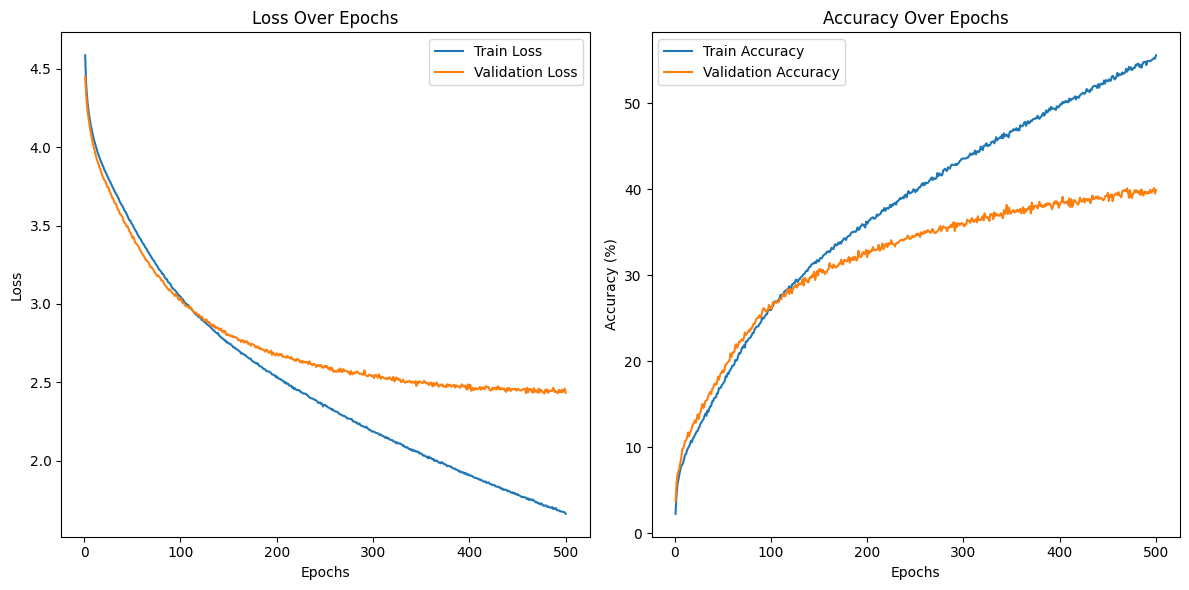

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(log_dir, "training_results.png"))
plt.show()